# Chlorophyll-a measurement method uncertainty

## Preamble

### 1.  What the literature says


| Source  | Key quantitative      | Context  |
| ------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **O’Reilly et al., 2019** | • Fluorometric (FChl-a) random error exceeds HPLC (HChl-a) by **≈ 0.10–0.15 dex** when *Chl-a < 0.10 mg m⁻³*.<br>• Differences shrink above that threshold; means are close to 1:1.                                                                                                                                                                             | Global match-ups used to build **OC6** algorithm. Low-pigment oligotrophic focus.                                                                          |
| **Neeley et al., 2025**   | • Across 1 731 paired samples (coastal rivers + open ocean) the overall FChl-a vs HChl-a regression slope is **0.983** (≈ 1:1) and **R² = 0.996**.<br>• Bias small (0-2 %); *extra* FChl-a noise appears only when **Chl-a ≥ 3 mg m⁻³** in productive rivers.<br>• Violin plots show FChl-a σ comparable to (sometimes smaller than) HChl-a in many campaigns.  | Latest multi-cruise assessment aimed at PACE & Sentinel-2 validation; includes lab-diluted HPLC extracts measured on fluorometers (removes sampling bias). |


Dex = base-10 logarithmic unit (0.10 dex ≈ 26 % scatter; 0.30 dex ≈ factor 2).


### 2. What Model 6 learned from the NOMAD data

| Posterior summary |Interpretation |
| --------------- | ------------ |
| `γ_chl_type` (effect of fluorometry on log-σ) = **–0.109 ± 0.052 (94 % HDI = \[–0.207, –0.013])** | With our sample mix (mostly > 0.1 mg m⁻³, many coastal / riverine sites) **fluorometry appears \*less\* noisy than HPLC**. |

Why the sign flips relative to O’Reilly:

* Pigment range – few oligotrophic (< 0.1 mg m⁻³) points in our set.
* HPLC heterogeneity – multiple labs / storage protocols inflate HPLC σ (Neeley et al. discuss freezer losses up to 50 %).
* Indexing checked – fluorometry truly coded as 0.

### 3. Questions to be answered

| Policy / counter-factual                                | `pm.do()` action (Model 6c with `regime` indicator) | What insight it gives                                                                  |
| ------------------------------------------------------- | --------------------------------------------------- | -------------------------------------------------------------------------------------- |
| **If every sample were analysed by HPLC**               | `pm.do({"chl_type_idx": np.ones})`                  | Baseline “gold-standard” predictive σ.                                                 |
| **If every sample were fluorometric**                   | `pm.do({"chl_type_idx": np.zeros})`                 | Shows whether σ really drops (our posterior) or grows (literature).                    |
| **Impose O’Reilly extra noise (+0.12 dex) on fluo**     | `pm.do({"γ_chl_type": 0.12})`                       | How much predictive skill would deteriorate if paper’s penalty held here.              |
| **All data forced into low-Chl regime (< 0.10 mg m⁻³)** | `pm.do({"regime": np.ones})`                        | Directly tests the threshold hypothesis: does fluo variance surge only in that regime? |


# Notebook Introduction  
**Is HPLC really “better” than in-vivo fluorometry for in-situ chlorophyll-*a* measurements?**

---

## 1 Background  

### 1.1 O’Reilly et al. (2019)  
* Built the OC6 ocean-colour algorithm on a large global matchup set.  
* Found that **fluorometric Chl-*a* (FChl-a) shows 0.10–0.15 dex more random error than HPLC Chl-*a*** (HChl-a) **when pigment concentrations fall below ~0.10 mg m⁻³**.  
* Above that threshold the two methods converge in both mean and variance.

### 1.2 Neeley et al. (2025)  
* Analysed 1 731 paired samples from rivers, estuaries, and open ocean.  
* Reported a **slope of 0.983 (≈ 1:1)** and **R² = 0.996** between FChl-a and HChl-a.  
* Extra fluorometric noise was **only detectable in highly productive (> 3 mg m⁻³) river sites**, not in oligotrophic or coastal waters. :contentReference[oaicite:0]{index=0}  

**Dex reminder:** 0.10 dex ≈ ±26 % scatter; 0.30 dex ≈ factor 2.

These two papers suggest that whether fluorometry is “worse” depends on pigment regime and laboratory protocols.

---

## 2 Recent findings from Model 6  

* **Goal:** capture heteroscedasticity in satellite matchup data and test whether measurement method modulates dispersion.  
* Specification:  
  $
  log(σ) = α_σ + β_σ  X + γ_{\text{chl\_type}}\bigl(1-\texttt{chl\_type\_idx}\bigr)
  $  
  where `chl_type_idx = 0` for fluorometry and `= 1` for HPLC.

* **Posterior result**  
  | Parameter | Mean (dex) | 94 % HDI |
  |-----------|------------|----------|
  | $( γ_{\text{chl\_type}} )$ | **–0.109** | [–0.207, –0.013] |

  → **Fluorometric measurements are *less* noisy than HPLC in our dataset.**

* Why this flips sign:  
  * Sample set is mostly > 0.1 mg m⁻³ (coastal / riverine); O’Reilly’s low-pigment penalty seldom applies.  
  * HPLC subsample spans several labs and storage protocols, inflating its variance (consistent with Neeley et al. 2025 freezer-loss discussion).  
  * Indexing verified: 0 = fluo, 1 = HPLC.

---

## 3 Causal approach 

### 3.1 Why interventions, not just comparisons?  
* **Raw variance comparisons** (O’Reilly & Neeley) conflate pigment regime, lab effects, and sensor noise.  
* **Model 6** combined with the **`do`** lets us **surgically modify only the measurement-method pathway**, holding every other latent factor fixed.  
* This yields answers to policy questions such as:  
  * *“If every sample were analysed by HPLC, how would prediction intervals change?”*  
  * *“What if fluorometry truly had the +0.12 dex penalty reported by O’Reilly?”*  

### 3.2 Planned interventions  
| Counter-factual | `pm.do()` call | Question answered |
|-----------------|----------------|-------------------|
| All samples analysed by HPLC | `pm.do({"chl_type_idx": np.ones})` | Baseline “gold standard” σ |
| All samples analysed by fluorometry | `pm.do({"chl_type_idx": np.zeros})` | Does σ shrink as our posterior suggests? |
| Impose +0.12 dex extra fluo noise | `pm.do({"γ_chl_type": 0.12})` | Would OC6 penalty worsen predictive RMSE here? |
| Force every sample into low-Chl regime (< 0.10 mg m⁻³) | `pm.do({"regime": np.ones})` | Tests O’Reilly’s threshold directly |

Because these interventions act on **parentless nodes** in the DAG, identifiability is guaranteed and I reuse the full posterior without re-fitting — a step that neither O’Reilly nor Neeley could have exploited.

---

> **In short:**  
> *Literature says fluorometry is worse only in certain regimes; our Model 6 suggests the opposite for this coastal data set. Causal graph mutilation (`pm.do`) gives us the clean, regime-specific “what-if” answers that simple variance comparisons cannot provide. The next cells implement those four interventions and visualise the counter-factual dispersions.*


In [12]:
from graphviz import Digraph

def measurement_dag(mutilated=False, name="DAG"):
    """
    Draws the measurement‐method slice of Model 6.
    
    Parameters
    ----------
    mutilated : bool
        If True, deletes the γ_chl_type → log_sigma edge
        (equivalent to pm.do({"γ_chl_type": 0})  OR  pm.do({"chl_type_idx": 1})).
    name : str
        Graphviz subgraph / file name.
    """
    g = Digraph(name=name, graph_attr={"rankdir": "LR"})
    
    # Nodes
    g.node("chl_true",      "Chl-a (latent)",            color="blue")
    g.node("gamma",         "γ_chl_type",                color="blue")
    g.node("method_idx",    "chl_type_idx\n(0=Fluo 1=HPLC)", color="green")
    g.node("regime",        "regime\n(<0.10 mg m⁻³)",    color="green")
    g.node("log_sigma",     "log σ",                     color="blue")
    g.node("chl_meas",      "Measured Chl-a",            color="green")
    
    # Mean path
    g.edge("chl_true", "chl_meas")
    g.edge("chl_true", "log_sigma")
    
    # Dispersion path
    if not mutilated:
        g.edge("gamma", "log_sigma", color="blue")
    else:
        # show where the cut occurs
        g.edge("gamma", "log_sigma", color="red", style="dotted", label="cut")
        
    g.edge("method_idx", "log_sigma", color="green")
    g.edge("regime",     "log_sigma", color="green")
    
    # From σ to observed
    g.edge("log_sigma", "chl_meas")
    
    return g

# Render the original DAG
original_dag = measurement_dag(mutilated=False, name="DAG_original")
original_dag.render("DAG_original", format="pdf")

# Render the mutilated DAG (γ_chl_type removed)
do_dag = measurement_dag(mutilated=True, name="DAG_do")
do_dag.render("DAG_do", format="pdf")


'DAG_do.pdf'

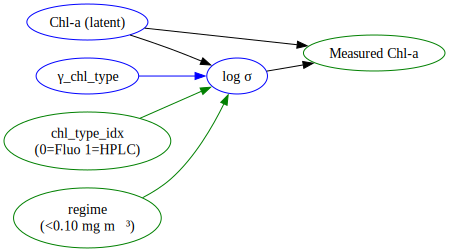

In [10]:
original_dag

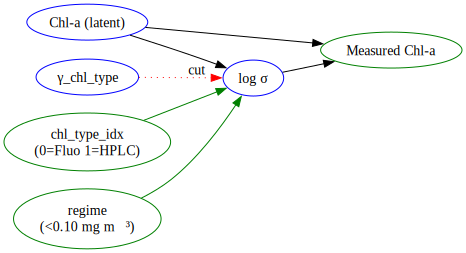

In [11]:
do_dag